In [33]:
import re
def assign_category(description): #EXXO NMOBIL
    if re.search( r"(^EXXO\s*N|^SPEEDWAY|^MAIN\s+ST\s+GAS|^SUNOCO|GULF\s+OIL|CITGO|MAIN ST(REET)? GAS).*?", str(description), re.IGNORECASE):
        return "Gas"
    elif re.search( r"^Costco\s+Annual\s+Membership\s+Renewal", str(description), re.IGNORECASE):
        return "Fees and Adjustments"
    elif re.search( r"(^COST\s*CO\s+WHSE.*?|WWW COSTCO COM)", str(description), re.IGNORECASE):
        return "Costco"
    elif re.search( r"^AMZN\s+.*?\s+GIFT\s+CARD.*?", str(description), re.IGNORECASE):
        return "Gift Card"
    elif re.search(r"(MCDONALD(')*S|TANDOORI|DOMINOS|5GUYS|PANDA PAVILLION|AMERICAN STEAKHOUSE|GYU-KAKU|TERIYAKI ONE|KARAVALLI|JAMROCK JERK|AUNTIE ANNES|BURGER KING|CAFE 1585|CENTRAL SEAFOOD HARTSDALE NY)", str(description),re.IGNORECASE):
        return "Food & Drink"
    elif re.search(r"(KITCHEN PARADISE|STARBUCKS|POPEYES|SGD DUBU|KUMO ULTIMATE SUSHI|Dinosaur Bar-B-Que|THAI SPICE|PANERA|DUNKIN|BIBBLE \& SIP|SHAKE SHACK|BBQ CHICKEN|\#1 ISTANBUL KEBAB HOUSE|TONY AND BENNYS|RED LOBSTER)", str(description),re.IGNORECASE):
        return "Food & Drink"
    elif re.search(r"(ENCHANTED SZECHUAN NORWALK CT|FIVE GUYS|FOOD COURT JAMAICA NY|GYRO GYRO HARTSDALE NY|GYROWORLD FLUSHING NY|HSD FOOD COURT|KFC|Kumo Sush|Lao Si Chua|MID HUDSON BUFFET KINGSTON NY|MINAR|MISTI CAFE|PEPPER LUNCH|POLLO A LA BRASA MIST)", str(description),re.IGNORECASE):
        return "Food & Drink"   
    elif re.search(r"(TACO BELL|TANDORI TASTE OF INDIA|THAI BASIL|THE BUFFET COLLEGE POINT NY|GO! GO! CURRY|WETZEL'S|Yellowtail Hibachi|YUM YUM TOO|ZIBETTO ESPRESSO|BUFFALO WILD WINGS|FANTASY CUISINE)", str(description),re.IGNORECASE):
        return "Food & Drink"
    elif re.search(r"(PATISSERIE DIDIER DUMAS NYACK NY)", str(description),re.IGNORECASE):
        return "Food & Drink"
    elif re.search(r"(TRADER JOE|H MART|FUJI MART|SHOPRITE|WAL-MART|ALDI|ASIA BAZAAR|CHANG JIANG SUPERMARKE FLUSHING NY|GOLD CITY SUPERMARKET FLUSHING NY|GOOD FORTUNE SUPERMARK|HUA LIAN SUPERMARKET|LA PLACITA|C \& A SUPERMARKET|STEW LEONARDS|GMART MILFORD CT)", str(description),re.IGNORECASE):
        return "Groceries"
    elif re.search(r"(KUMO GROCERY STAMFORD CT)", str(description),re.IGNORECASE):
        return "Groceries"
    elif re.search(r"(TMOBILE|CT NATURAL GAS|CONNECTICUT NATURAL)", str(description),re.IGNORECASE):
        return "Bills & Utilities"
    elif re.search(r"(CHATGPT|OPENAI)", str(description),re.IGNORECASE):
        return "Subscriptions"
    elif re.search(r"(CVS\/PHARMACY)", str(description),re.IGNORECASE):
        return "Pharmacy"
    elif re.search(r"(MARCUS MAYUS|GandelmanCardiology|RYE ORAL SURGERY|WESTCHESTER AVE DENTAL|GARRICK F WONG|RYE PERIODONTICS)", str(description),re.IGNORECASE):
        return "Health & Wellness"
    elif re.search(r"(EVA AIR|CATHAYPACAIR)", str(description),re.IGNORECASE):
        return "Travel"
    else:
        return "Shopping"

In [1]:
import pandas as pd
import glob
import os

accounts_df = []
spending_df = pd.DataFrame()
directory_path = "/Users/kingwanlau/Downloads"
csv_files = glob.glob(os.path.join(directory_path, "Chase*.CSV"))
for i, csv_file in enumerate(csv_files):
    if i == 0:
        spending_df = pd.read_csv(csv_file)
    else:
        spending_df = pd.concat([spending_df,pd.read_csv(csv_file)], ignore_index=True)


# Remove rows for Auto Payment
spending_df = spending_df[spending_df["Type"] != "Payment"]

# drop columns
spending_df = spending_df.drop(columns=["Post Date", "Memo", "Type", "Card"])

# convert to datetime type
spending_df["Transaction Date"] = pd.to_datetime(spending_df["Transaction Date"], format="%m/%d/%Y")

# Convert Amount into Positive for better charting
spending_df["Amount"] = spending_df["Amount"]*-1.0

spending_df = spending_df.sort_values(by="Transaction Date", ascending=False)



In [48]:
import pdfplumber
import re
import os
import glob

citibank_spending_df = pd.DataFrame()
directory_path = "/Users/kingwanlau/Downloads/spending/citi"
citibank_spending_csvs = glob.glob(os.path.join(directory_path, "Citi*.CSV"))

for citibank_spending_csv in citibank_spending_csvs:
    if citibank_spending_df.empty:
        citibank_spending_df = pd.read_csv(citibank_spending_csv)
    else:
        citibank_spending_df = pd.concat([citibank_spending_df,pd.read_csv(citibank_spending_csv)], ignore_index=True)

# assign Credit to Debit if it is not in NaN
citibank_spending_df.loc[citibank_spending_df["Credit"].notna(),"Debit"] =citibank_spending_df["Credit"] #*-1.0

# drop columns
citibank_spending_df = citibank_spending_df.drop(columns=["Status", "Member Name", "Credit"])

# delete rows for Auto Payment
citibank_spending_df = citibank_spending_df[~citibank_spending_df["Description"].str.contains(r"^AUTOPAY\s+.*?\s+AUTO-PMT$", na=False, regex=True)]

# rename column
citibank_spending_df = citibank_spending_df.rename(columns={"Date": "Transaction Date", "Debit": "Amount"})

# convert to datetime type
citibank_spending_df["Transaction Date"] = pd.to_datetime(citibank_spending_df["Transaction Date"], format="%m/%d/%Y")

directory_path = "/Users/kingwanlau/Downloads/spending/citi"
pdf_files = glob.glob(os.path.join(directory_path, "*.pdf"))
activities = []
# activities = [('Transaction Date','Description','Amount')]
for pdf_file in pdf_files:
    month, year = os.path.basename(pdf_file).split(".")[0].split(" ")
    this_activites = []
    with pdfplumber.open(pdf_file) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            # this_activites += re.findall(r"(\d{2}\/\d{2})\s+\d{2}\/\d{2}\s+(.*?)\s+(-?\$\d{1,3}(?:,\d{3})*(?:\.\d{2})?|\d+(?:\.\d{2})?)\n", text)
            this_activites += re.findall(r"(\d{2}\/\d{2})\s+\d{2}\/\d{2}(\s+.*?\s+|\s)(-?\$\d{1,3}(?:,\d{3})*(?:\.\d{2})?)", text)
    for i, activity in enumerate(this_activites):
        txn_date = activity[0] + "/" + (str(int(year)-1) if activity[0][:2] == "12" and month == "01" else year)
        this_activites[i] = (txn_date, activity[1].strip(), activity[2].replace("$",""))  # Update the tuple at index i
    activities += this_activites

old_spending_df = pd.DataFrame(activities, columns=['Transaction Date','Description','Amount'])
old_spending_df["Transaction Date"] = pd.to_datetime(old_spending_df["Transaction Date"], format="%m/%d/%Y")
citibank_spending_df = pd.concat([old_spending_df,citibank_spending_df], ignore_index=True)

# insert a column 
citibank_spending_df.insert(2, "Category", "Shopping")

# assign Category base on Description
citibank_spending_df["Category"] = citibank_spending_df["Description"].apply(assign_category)

citibank_spending_df = citibank_spending_df.sort_values(by="Transaction Date", ascending=False)


In [49]:
citibank_spending_df["Category"] = citibank_spending_df["Description"].apply(assign_category)
citibank_spending_df = citibank_spending_df.sort_values(by="Transaction Date", ascending=True)

citibank_spending_df.to_csv("citi-pdf2.csv", index=False, header=True)


In [ ]:
import re
import pandas as pd

# def assign_category(description):
#     if re.search( r"(^EXXON|^SPEEDWAY|^MAIN\s+ST\s+GAS|^SUNOCO|GULF\s+OIL|CITGO|MAIN STREET GAS).*?", str(description), re.IGNORECASE):
#         return "Gas"
#     elif re.search( r"^Costco\s+Annual\s+Membership\s+Renewal", str(description), re.IGNORECASE):
#         return "Fees and Adjustments"
#     elif re.search( r"^COSTCO\s+WHSE.*?", str(description), re.IGNORECASE):
#         return "Costco"
#     elif re.search( r"^AMZN\s+.*?\s+GIFT\s+CARD.*?", str(description), re.IGNORECASE):
#         return "Gift Card"
#     elif re.search(r"(MCDONALD(')*S|TANDOORI|DOMINOS|5GUYS|PANDA PAVILLION|AMERICAN STEAKHOUSE|GYU-KAKU|TERIYAKI ONE|KARAVALLI|JAMROCK JERK|AUNTIE ANNES|BURGER KING|CAFE 1585|CENTRAL SEAFOOD HARTSDALE NY)", str(description),re.IGNORECASE):
#         return "Food & Drink"
#     elif re.search(r"(KITCHEN PARADISE|STARBUCKS|POPEYES|SGD DUBU|KUMO ULTIMATE SUSHI|Dinosaur Bar-B-Que|THAI SPICE|PANERA|DUNKIN|BIBBLE \& SIP|SHAKE SHACK|BBQ CHICKEN|\#1 ISTANBUL KEBAB HOUSE|TONY AND BENNYS|RED LOBSTER)", str(description),re.IGNORECASE):
#         return "Food & Drink"
#     elif re.search(r"(ENCHANTED SZECHUAN NORWALK CT|FIVE GUYS|FOOD COURT JAMAICA NY|GYRO GYRO HARTSDALE NY|GYROWORLD FLUSHING NY|HSD FOOD COURT|KFC|Kumo Sush|Lao Si Chua|MID HUDSON BUFFET KINGSTON NY|MINAR|MISTI CAFE|PEPPER LUNCH|POLLO A LA BRASA MIST)", str(description),re.IGNORECASE):
#         return "Food & Drink"   
#     elif re.search(r"(TACO BELL|TANDORI TASTE OF INDIA|THAI BASIL|THE BUFFET COLLEGE POINT NY|GO! GO! CURRY|WETZEL'S|Yellowtail Hibachi|YUM YUM TOO|ZIBETTO ESPRESSO|BUFFALO WILD WINGS|FANTASY CUISINE)", str(description),re.IGNORECASE):
#         return "Food & Drink"     
#     elif re.search(r"(TRADER JOE|H MART|FUJI MART|SHOPRITE|WAL-MART|ALDI|ASIA BAZAAR|CHANG JIANG SUPERMARKE FLUSHING NY|GOLD CITY SUPERMARKET FLUSHING NY|GOOD FORTUNE SUPERMARK|HUA LIAN SUPERMARKET|LA PLACITA|C \& A SUPERMARKET|STEW LEONARDS)", str(description),re.IGNORECASE):
#         return "Groceries"
#     elif re.search(r"(TMOBILE|CT NATURAL GAS|CONNECTICUT NATURAL)", str(description),re.IGNORECASE):
#         return "Bills & Utilities"
#     elif re.search(r"(CHATGPT|OPENAI)", str(description),re.IGNORECASE):
#         return "Subscriptions"
#     elif re.search(r"(CVS\/PHARMACY)", str(description),re.IGNORECASE):
#         return "Pharmacy"
#     elif re.search(r"(MARCUS MAYUS|GandelmanCardiology|RYE ORAL SURGERY|WESTCHESTER AVE DENTAL|GARRICK F WONG|RYE PERIODONTICS)", str(description),re.IGNORECASE):
#         return "Health & Wellness"
#     elif re.search(r"(EVA AIR|CATHAYPACAIR)", str(description),re.IGNORECASE):
#         return "Travel"
#     else:
#         return "Shopping"

# activities_pd = pd.read_csv("./Chase-2018010-20231231.csv", on_bad_lines='skip', delimiter=',', parse_dates=['Transaction Date'], date_format="%m/%d/%Y")
activities_pd = pd.read_csv("./citi-pdf.csv", on_bad_lines='skip', delimiter=',', parse_dates=['Transaction Date'], date_format="%m/%d/%Y")

# delete rows for Auto Payment
activities_pd = activities_pd[~activities_pd["Description"].str.contains(r"^AUTOMATIC\s+PAYMENT", na=False, regex=True)]
activities_pd = activities_pd[~activities_pd["Description"].str.contains(r"^Payment\s+Thank\s+You", na=False, regex=True)]


activities_pd.insert(2, "Category", "Shopping")
activities_pd["Category"] = activities_pd["Description"].apply(assign_category)

activities_pd = activities_pd.sort_values(by="Transaction Date", ascending=False)


activities_pd[activities_pd["Category"]=="Shopping"].head(30)

activities_pd = activities_pd.sort_values(by="Transaction Date", ascending=False)

activities_pd[activities_pd["Amount"] == -108.36]


,Transaction Date,Description,Category,Amount


In [5]:
spending_df = activities_pd

In [4]:
spending_df = pd.concat([spending_df,citibank_spending_df,activities_pd], ignore_index=True)
spending_df = spending_df.sort_values(by="Transaction Date", ascending=False)
spending_df.to_csv(f"combined3.csv", index=False)


<Figure size 1400x700 with 0 Axes>

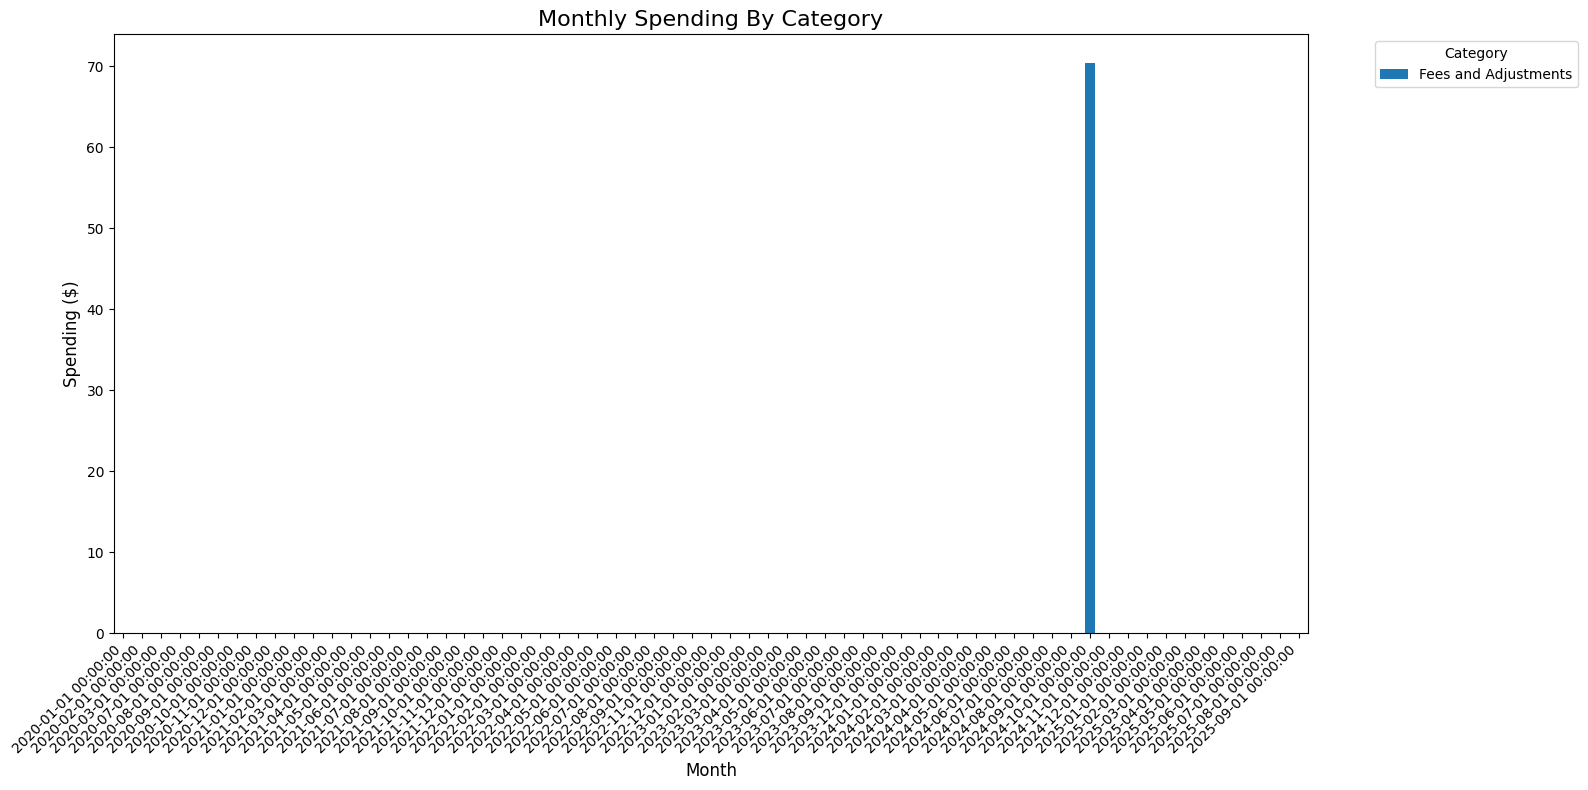

In [35]:
import matplotlib.pyplot as plt

# spending_df = citibank_spending_df

monthly_category_spending = (
    citibank_spending_df.groupby([citibank_spending_df['Transaction Date'].dt.to_period('M'), 'Category'])['Amount']
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)

monthly_category_spending.index = monthly_category_spending.index.to_timestamp()

plt.figure(figsize=(14,7))
monthly_category_spending.plot(kind='bar', stacked=True, figsize=(16,8))

plt.title('Monthly Spending By Category', fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Spending ($)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



In [ ]:
spending_df[spending_df["Category"] == "Costco"].head(50)